In [1]:
pip install faiss-cpu transformers torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 43.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import faiss
import torch
import json
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from torchvision import models, transforms
from PIL import Image
import numpy as np
import os
import pickle
from IPython.display import display

In [4]:
image_dir='/content/drive/MyDrive/tell2design/floorplan_image'
json_path='/content/drive/MyDrive/tell2design/json/descriptions_artificial.json'
for_displaying_image='/content/drive/MyDrive/tell2design'

In [5]:
faiss_index_path = "/content/drive/MyDrive/tell2design/model/floorplan_text_full_faiss.index"
metadata_path = "/content/drive/MyDrive/tell2design/model/metadata_full.pth"

In [6]:
# Function to convert a query text to an embedding
def query_to_embedding(query_text):
    # Convert the query text to an embedding with truncation to max length
    inputs = tokenizer(query_text, return_tensors="pt", max_length=512, truncation=True)
    with torch.no_grad():
        query_embedding = text_model(**inputs).last_hidden_state.mean(dim=1).squeeze().numpy()
    # print("query embedding:",query_embedding)
    return query_embedding

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<ipython-input-10-1775efcb0376>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

Rank 1: Image Location: /content/drive/MyDrive/tell2design/floorplan_image/16381.png, Distance: 6.289924635825839e-13


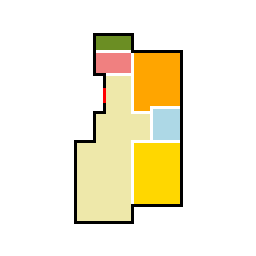

Rank 2: Image Location: /content/drive/MyDrive/tell2design/floorplan_image/21160.png, Distance: 0.23833566904067993


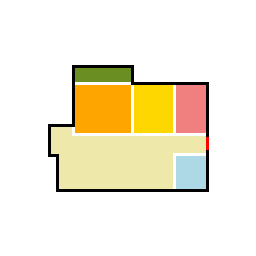

Rank 3: Image Location: /content/drive/MyDrive/tell2design/floorplan_image/73614.png, Distance: 0.2427816540002823


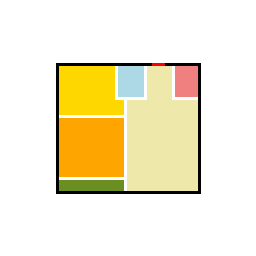

In [10]:
image_dir = '/content/drive/MyDrive/tell2design/trained_floorplan_images'

# Initialize tokenizer and model for text embeddings
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
text_model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
text_model.eval()

# Load the Faiss index
index = faiss.read_index(faiss_index_path)

# Load the metadata (mapping of Faiss indices to image paths)
# try:
    # Attempt to load as a torch dictionary (common for dictionaries saved with torch.save)
metadata = torch.load(metadata_path, map_location="cpu")
# except AttributeError:
#     # Fallback to loading as a pickle if the above fails
#     with open(metadata_path, "rb") as f:
#         metadata = pickle.load(f)

def retrieve_top_images_from_text(query_text, k=3):
    # Convert the query to a text vector
    query_embedding = query_to_embedding(query_text)

    # Search Faiss index for the closest k matching text vectors
    D, I = index.search(query_embedding.reshape(1, -1), k=k)

    for rank in range(k):
        closest_text_index = I[0][rank]  # Get the index of the current closest match
        distance = D[0][rank]  # Get the corresponding distance score

        # Retrieve the filename and construct the full path
        closest_image_filename = os.path.basename(metadata[closest_text_index])  # Only get filename
        closest_image_path = os.path.join(for_displaying_image, closest_image_filename).replace("\\", "/")
        print(f"Rank {rank + 1}: Image Location: {closest_image_path}, Distance: {distance}")

        # Load and display the image along with its score
        if os.path.exists(closest_image_path):
            image = Image.open(closest_image_path)
            display(image)  # Display the image inline
        else:
            print(f"Image not found: {closest_image_path}")

# Example usage
query = "I want a living room at the northwest corner with a balcony in the south."
query1 = "The balcony is at the north corner. near common room2 and master room. 10x6 sq ft. The bathroom is at the east and south middle of the corner. between kitchen and living room. 10x6 sq ft. Common room 1 is at the west and north middle corner. between living room and common room 2. 10x10 sq ft. Common room 2 is at the north center corner. between common room1 and master room. 10x10 sq ft. The kitchen is at the south middle  corner. between living room and bathroom. 10x8 sq ft. living room is center position. east face. 10x16 sq ft. The master room is at the north and east middle corner. between balcony and storage. 10x14 sq ft. The storage room is at the east corner. between master room and living room. 10x8 sq ft. "
query3="The bathroom is located on the east side, It is next to living and kitchen, The size of the room is 4 feet width  and 5  feet length The common room is located on the south west corner, It is next to living and master , The size of the room is 10  feet width  and 10  feet length The kitchen is located on the north east corner, It is next to living and bath, The size of the room is 7 feet width  and  8 feet length The living room is located on the north side, It is in front of all other rooms, The size of the room is 12   feet width  and  27  feet length The master room is located on the south side, It is next to living and near to common,The size of the room is 10  feet width  and  11  feet length The storage room is located on the east side,it is inside southeast corner of kitchen,The size of the room is 2  feet width  and 2  feet length "
query4="It would be good to have a common room . I would like to place common room at the north side of the apartment. The common room should be around 200 sqft with the aspect ratio of 3 over 4. The common room should have an en-suite bathroom. The common room should be next to the bathroom, kitchen, balcony. The bathroom should be considered. Place bathroom at the south side of the apartment. Make bathroom around 50 sqft with the aspect ratio of 7 over 8. The bathroom can be used by guest. The bathroom connects to the common room, master room, living room. Make a kitchen . The kitchen should be at the south side of the apartment. Make kitchen approx 50 sqft with the aspect ratio of 7 over 4. The kitchen attaches to the common room, balcony, master room, living room. Can you make a balcony ? I would like to place balcony at the south side of the apartment. Can you make balcony around 50 sqft with the aspect ratio of 5 over 2? The balcony is private. The balcony connects to the common room, kitchen, master room. The master room should be considered. The master room should be at the south side of the apartment. Make master room approx 150 sqft with the aspect ratio of 4 over 5. The master room should have an en-suite bathroom. The master room should be next to the bathroom, kitchen, balcony. It would be great to have a living room . Make living room around 650 sqft with the aspect ratio of 1 over 2."
retrieve_top_images_from_text(query4)